In [17]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [18]:
class LensDataset(Dataset):
    def __init__(self, lens_dir, nonlens_dir, transform=None):
        """
        lens_dir: directory with npy files of lensed galaxies (label 1)
        nonlens_dir: directory with npy files of non-lensed galaxies (label 0)
        """
        self.transform = transform
        
        self.lens_files = glob.glob(os.path.join(lens_dir, '*.npy'))
        self.nonlens_files = glob.glob(os.path.join(nonlens_dir, '*.npy'))
        
        self.data = [(f, 1) for f in self.lens_files] + [(f, 0) for f in self.nonlens_files]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        filepath, label = self.data[idx]
        #loading the image from npy file, ensuring float32
        image = np.load(filepath).astype(np.float32)

        #currently no transform as seems to be wokring fine without it
        if self.transform:
            image = self.transform(image)

        image = torch.tensor(image)

        return image, torch.tensor(label, dtype=torch.float32)


In [34]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        #convolutional layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # (3,64,64) -> (32,64,64)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (32,64,64) -> (32,32,32)
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (32,32,32) -> (64,32,32)
            nn.ReLU(),
            nn.MaxPool2d(2),  # (64,32,32) -> (64,16,16)
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # (64,16,16) -> (128,16,16)
            nn.ReLU(),
            nn.MaxPool2d(2)   # (128,16,16) -> (128,8,8)
        )

        #FC layers
        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 1)  # outputting single logit for binary classification
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        return x
    

class NewCNN(nn.Module):
    def __init__(self):
        super(NewCNN, self).__init__()
        
        #convolutional layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # (3,64,64) -> (64,64,64)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (64,64,64) -> (64,32,32)
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # (64,32,32) -> (128,32,32)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (128,32,32) -> (128,16,16)
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # (128,16,16) -> (256,16,16)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),   # (256,16,16) -> (256,8,8)
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), # (256,8,8) -> (512,8,8)
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)   # (512,8,8) -> (512,4,4)
        )

        #FC layers
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1) # outputting single logit for binary classification
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [41]:
def get_sampler(dataset):
    #the number of samples per class
    labels = [label.item() for _, label in dataset]
    class_sample_count = np.array([sum(np.array(labels)==t) for t in [0, 1]])

    print('Class counts:', class_sample_count)
    
    # Inverse frequency for weighting: the minority class gets higher weight
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[int(label)] for label in labels])
    samples_weight = torch.from_numpy(samples_weight).float()
    sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)
    print('Class weights:', weight)
    
    return sampler

#the equation for this is:
#TPR = TP/(TP+FN)
#FPR = FP/(FP+TN)



In [21]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if batch_idx % 10 == 0:
            print(f"Epoch {epoch} [{batch_idx * len(inputs)}/{len(train_loader.dataset)}] Loss: {loss.item():.4f}")
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch} Average Loss: {epoch_loss:.4f}")

In [26]:
def evaluate(model, device, test_loader):
    model.eval()
    all_targets = []
    all_outputs = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            # Apply sigmoid to get probabilities
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            all_outputs.extend(probs)
            all_targets.extend(targets.numpy().flatten())
    
    
    fpr, tpr, thresholds = roc_curve(all_targets, all_outputs)
    roc_auc = auc(fpr, tpr)
    
    #pllot ROC curve
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC graph')
    plt.legend(loc="lower right")
    plt.show()
    
    print(f"AUC Score: {roc_auc:.3f}")
    return roc_auc

Class counts: [28675  1730]
Class weights: [3.48735833e-05 5.78034682e-04]


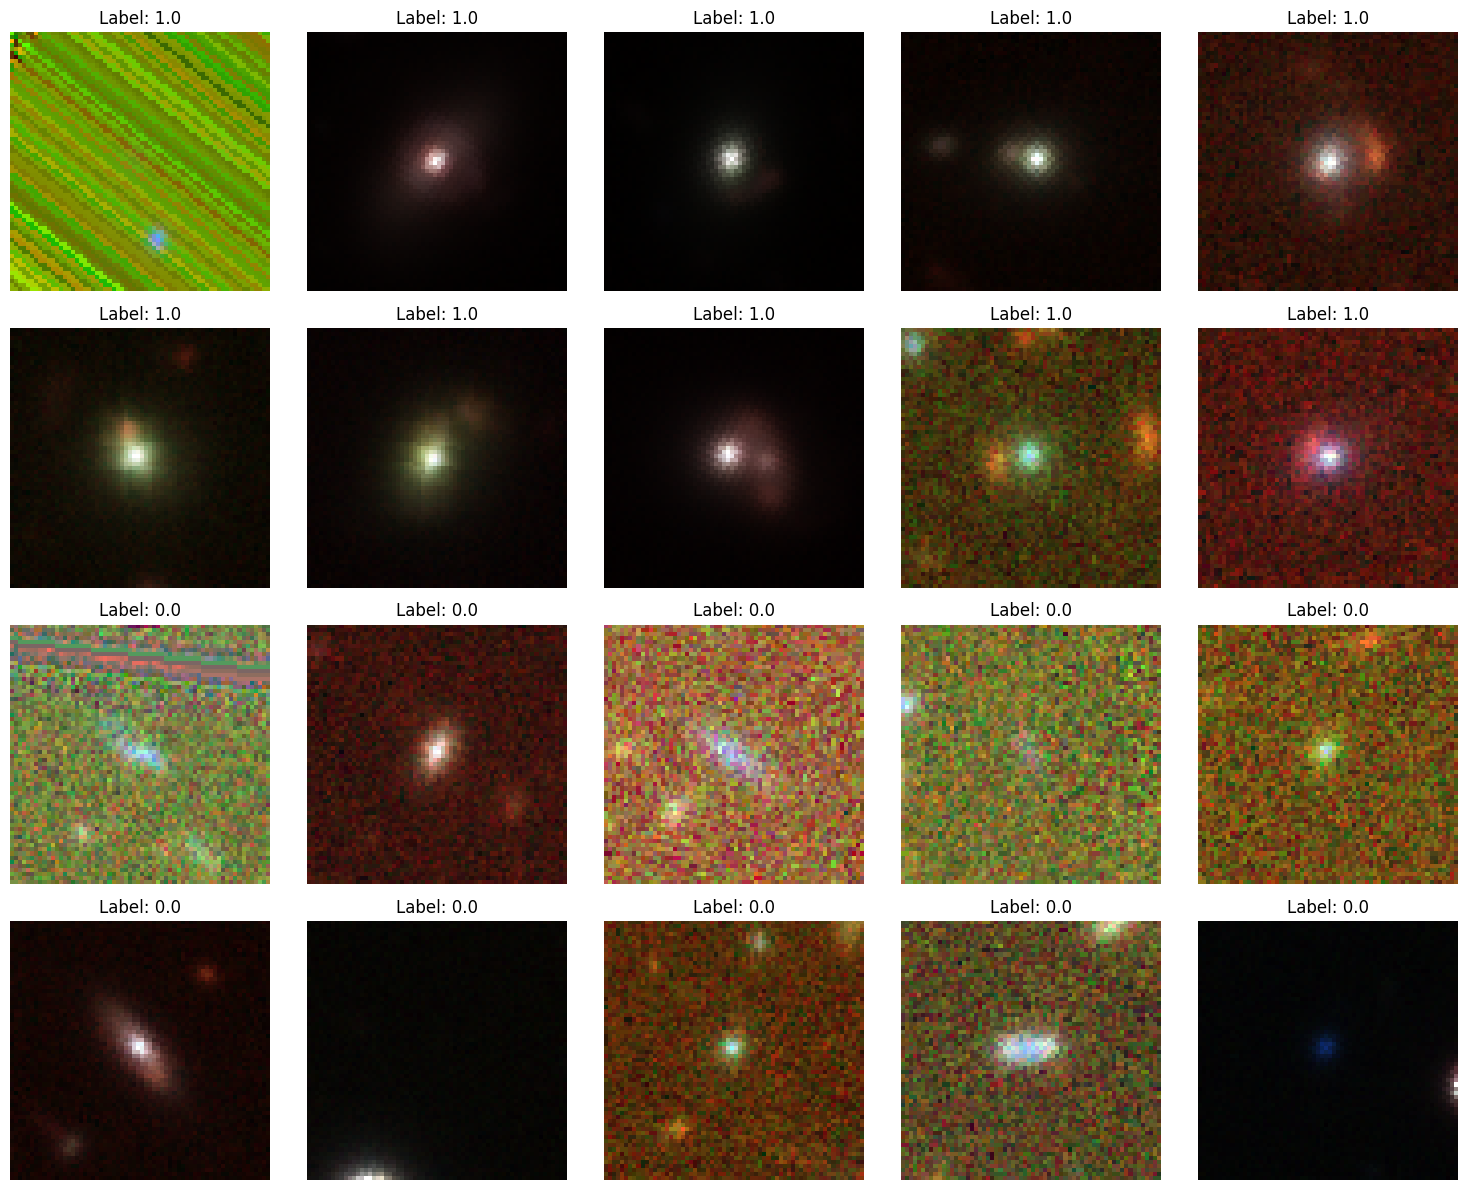

In [43]:
train_lens_dir = '/home/vimarsh/Desktop/3-2/GSoC/ML4Sci/lens-finding-test/train_lenses'
train_nonlens_dir = '/home/vimarsh/Desktop/3-2/GSoC/ML4Sci/lens-finding-test/train_nonlenses'
test_lens_dir = '/home/vimarsh/Desktop/3-2/GSoC/ML4Sci/lens-finding-test/test_lenses'
test_nonlens_dir = '/home/vimarsh/Desktop/3-2/GSoC/ML4Sci/lens-finding-test/test_nonlenses'

train_dataset = LensDataset(train_lens_dir, train_nonlens_dir)
test_dataset = LensDataset(test_lens_dir, test_nonlens_dir)

#weighted sampler to address imbalance in the training set
train_sampler = get_sampler(train_dataset)


train_loader = DataLoader(train_dataset, batch_size=256, sampler=train_sampler, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#visualizing 20 random images as one subplot
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

#half images from each class
half = len(axes) // 2
lens_indices = np.random.choice(len(train_dataset.lens_files), half, replace=False)
nonlens_indices = np.random.choice(len(train_dataset.nonlens_files), half, replace=False)

for i, ax in enumerate(axes):
    if i < half:
        image, label = train_dataset[lens_indices[i]]
    else:
        image, label = train_dataset[len(train_dataset.lens_files) + nonlens_indices[i - half]]
    
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(f"Label: {label.item()}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [35]:

# Initialize model, optimizer and loss function
# model = SimpleCNN().to(device)
model = NewCNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 25
for epoch in range(1, num_epochs+1):
    train(model, device, train_loader, optimizer, criterion, epoch)

Epoch 1 [0/30405] Loss: 0.7199
Epoch 1 [2560/30405] Loss: 0.5752
Epoch 1 [5120/30405] Loss: 0.5257
Epoch 1 [7680/30405] Loss: 0.4569
Epoch 1 [10240/30405] Loss: 0.3806
Epoch 1 [12800/30405] Loss: 0.4036
Epoch 1 [15360/30405] Loss: 0.3138
Epoch 1 [17920/30405] Loss: 0.2895
Epoch 1 [20480/30405] Loss: 0.3176
Epoch 1 [23040/30405] Loss: 0.3184
Epoch 1 [25600/30405] Loss: 0.3212
Epoch 1 [28160/30405] Loss: 0.2458
Epoch 1 Average Loss: 0.4264
Epoch 2 [0/30405] Loss: 0.2294
Epoch 2 [2560/30405] Loss: 0.2513
Epoch 2 [5120/30405] Loss: 0.2607
Epoch 2 [7680/30405] Loss: 0.2212
Epoch 2 [10240/30405] Loss: 0.2136
Epoch 2 [12800/30405] Loss: 0.2297
Epoch 2 [15360/30405] Loss: 0.2809
Epoch 2 [17920/30405] Loss: 0.1575
Epoch 2 [20480/30405] Loss: 0.2053
Epoch 2 [23040/30405] Loss: 0.2068
Epoch 2 [25600/30405] Loss: 0.1522
Epoch 2 [28160/30405] Loss: 0.1564
Epoch 2 Average Loss: 0.2202
Epoch 3 [0/30405] Loss: 0.1831
Epoch 3 [2560/30405] Loss: 0.2022
Epoch 3 [5120/30405] Loss: 0.1874
Epoch 3 [7680/304

In [36]:
#saving all model parameters
torch.save(model.state_dict(), 'model.pth')
print("Model saved successfully")

Model saved successfully


In [38]:
#loading back the model
model = NewCNN().to(device)
model.load_state_dict(torch.load('model.pth'))
model.eval()
print("Model loaded successfully")

Model loaded successfully


/tmp/ipykernel_122426/1935435501.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


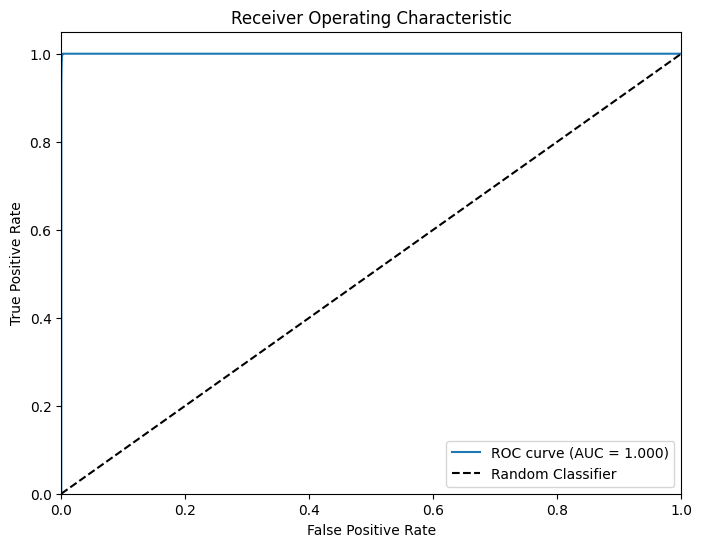

AUC Score: 1.000


0.9999243193127725

In [40]:
evaluate(model, device, train_loader)
#very very obvious overfitting on training data as the AUC score is 1.0

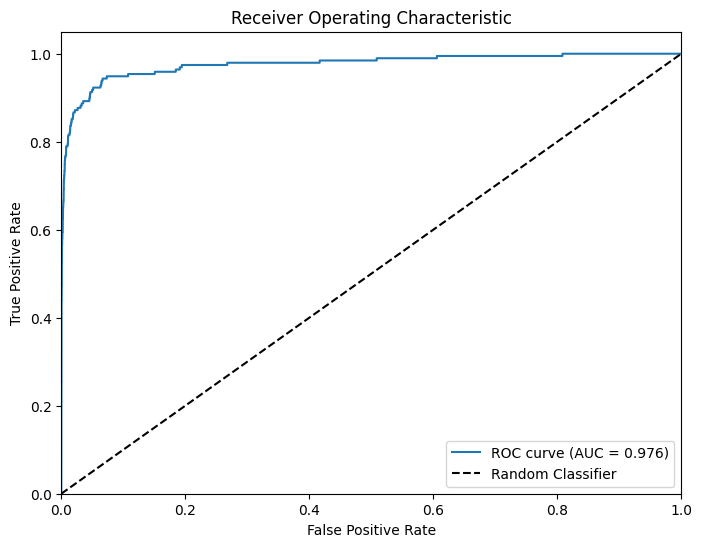

AUC Score: 0.976


0.9762439291197965

In [ ]:
evaluate(model, device, test_loader)
#The AUC score is 0.976 which is very good so the model is able to distinguish between lensed and non-lensed images with a high accuracy.